In [13]:
import rpy2
import rpy2.robjects.lib.ggplot2 as ggplot2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
base = importr('base')

# the base of rpy2 plotting is matplotlib, thus we need to declare
# it inline in order to see the plots in the notebook
%matplotlib inline

# we need to activate the automatic conversion for pandas
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# load the needed extension for the %%R cell magic
%load_ext rpy2.ipython

import numpy as np
import pandas as pd
import glob
import toml

%config IPCompleter.greedy=True

import matplotlib.pylab as plt
plt.rcParams['figure.dpi'] = 200

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [2]:
import ray
ray.init()

2023-04-12 10:29:55,347	INFO worker.py:1518 -- Started a local Ray instance.


Python version:,3.9.6
Ray version:,2.0.1


In [75]:
rootdir = "/Users/akshay/research/burrito"
outdirs = ["kv-mlx5-0a7efa1", "kv-shenango-mlx5-0a7efa1"]

In [76]:
# datapaths = ['kernel', 'dpdkthread', 'dpdkmulti', 'shenango_channel', 'shenango_rt', 'shenango_rt_nochunnels']
# datapaths = ['dpdkmulti', 'dpdkmulti_nochunnels', 'shenango_rt', 'shenango_rt_nochunnels']
# num_shards = [8,]
# #ops = [1000, 5000, 10000, 20000, 40000, 60000, 80000, 100000, 160000, 200000, 240000, 320000]
# ops = [10000, 20000, 40000, 60000, 80000, 100000, 120000, 140000, 160000, 180000, 200000, 240000, 280000, 320000, 360000, 400000]
# clients = ["10.10.1.1"]
# shard_types = ['client']
# client_concurrency = [8]
# poisson = [True]

def read_toml(cfg):
    return toml.load(cfg)['exp']

def merge_tomls(cfgs):
    merged_cfg = {}
    for cfg in cfgs:
        for key in cfg:
            if key in merged_cfg:
                if type(cfg[key]) != type(merged_cfg[key]):
                    raise Exception(f"mismatched config types: {cfg[key]} vs {merged_cfg[key]}")
                if type(cfg[key]) == int and merged_cfg[key] != cfg[key]:
                    raise Exception(f"int-valued configs must match: {cfg[key]} vs {merged_cfg[key]}")
                if type(cfg[key]) == list:
                    merged_cfg[key] = list(set(cfg[key]).union(set(merged_cfg[key])))
            else:
                merged_cfg[key] = cfg[key]
    return merged_cfg

tomls = {}
for outdir in outdirs:
    od = f"{rootdir}/{outdir}"
    cfgs = glob.glob(f"{od}/*.toml")
    tomls[outdir] = merge_tomls([read_toml(t) for t in cfgs])

tomls

{'kv-mlx5-0a7efa1': {'wrk': ['./kvstore-ycsb/ycsbc-mock/workloadb-8.access'],
  'datapath': ['dpdkmulti'],
  'load': [40000,
   80000,
   120000,
   160000,
   200000,
   240000,
   280000,
   320000,
   360000,
   400000,
   680000,
   760000,
   10000,
   480000,
   560000,
   20000,
   60000,
   100000,
   140000,
   180000,
   640000,
   720000,
   800000,
   440000,
   520000,
   600000],
  'poisson-arrivals': [True],
  'shardtype': ['server', 'client'],
  'shards': [8],
  'no-chunnels': [False, True]},
 'kv-shenango-mlx5-0a7efa1': {'wrk': ['./kvstore-ycsb/ycsbc-mock/workloadb-8.access'],
  'datapath': ['shenangort'],
  'load': [10000,
   20000,
   40000,
   60000,
   80000,
   100000,
   120000,
   140000,
   160000,
   180000,
   200000],
  'poisson-arrivals': [True],
  'shardtype': ['client'],
  'shards': [8],
  'no-chunnels': [True, False]}}

In [165]:
# note: this aggregates requestclients together

@ray.remote
def read_exp(outdir, dp, ns, st, o, p, c, iter_num):
    def get_clients():
        fn_wildcard = f"{rootdir}/{outdir}/{dp}-{ns}-{st}shard-{o}-poisson={p}-{c}-{iter_num}-client0-*.data"
        found = glob.glob(fn_wildcard)
        if len(found) == 0:
            raise Exception(f"no files for {fn_wildcard}")
        for exp in found:
            try:
                df_file = pd.read_csv(exp, sep=" ")
                df_file["ShardType"] = st
                df_file['NumShards'] = ns
                df_file["Ops"] = o
                df_file["Client"] = exp.split('-')[-1].split('.')[0]
                df_file = df_file[(df_file.NumOps > 200e3) & (df_file.NumShards > 1)]
                yield df_file
            except Exception as e:
                #print(e)
                continue
    
    try:
        exp_df = pd.concat(get_clients())
    except Exception:
        return pd.DataFrame()
        
    # now calculate this experiment's stats.
    # if we want to group by client, add "Client" to the groupby.
    exp_stats = exp_df.groupby(["ShardType", "NumShards", "Ops"]).quantile([0.05, 0.25, 0.5, 0.75, 0.95], numeric_only=True)
    exp_stats = exp_stats.unstack()
    exp_stats.columns = [f"{s}_{t}" for s,t in exp_stats.columns.values]
    exp_stats.columns.to_flat_index()
    exp_stats["Commit"] = outdir
    exp_stats["Datapath"] = dp
    exp_stats["Concurrency"] = c
    exp_stats["Poisson"] = p
    exp_stats["Iter"] = iter_num
    return exp_stats

In [150]:
def combos():
    for outdir in outdirs:
        cfg = tomls[outdir]
        datapaths = cfg['datapath']
        with_chunnels = cfg['no-chunnels']
        num_shards = cfg['shards']
        shard_types = cfg['shardtype']
        ops = cfg['load']
        poisson = cfg['poisson-arrivals']
        wrk = [x.split('/')[-1].split('.')[0] for x in cfg['wrk']]
        
        for dp in datapaths:
            for ch in with_chunnels:
                d = f"{dp}{'_nochunnels' if not ch else ''}"
                for ns in num_shards:
                    for st in shard_types:
                        for o in ops:
                            o = int(o)
                            for p in poisson:
                                for c in wrk:
                                    yield read_exp.remote(outdir, d, ns, st, o, p, c, 0)
                                    
exp_dfs = ray.get([x for x in combos()])
df = pd.concat(exp_dfs)
df = df.reset_index()
df

,ShardType,NumShards,Ops,Interarrival_us_0.05,Interarrival_us_0.25,Interarrival_us_0.5,Interarrival_us_0.75,Interarrival_us_0.95,NumOps_0.05,NumOps_0.25,...,Completion_ms_0.95,Latency_us_0.05,Latency_us_0.25,Latency_us_0.5,Latency_us_0.75,Latency_us_0.95,Commit,Datapath,Concurrency,Poisson
0,client,8,40000,400.0,400.0,400.0,400.0,400.0,1214020.0,1214020.0,...,61216.0,7.0,11.0,11.0,11.0,12.0,kv-mlx5-0a7efa1,dpdkmulti_nochunnels,workloadb-8,True
1,client,8,80000,200.0,200.0,200.0,200.0,200.0,1214019.0,1214019.0,...,30678.0,8.0,11.0,11.0,12.0,13.0,kv-mlx5-0a7efa1,dpdkmulti_nochunnels,workloadb-8,True
2,client,8,120000,133.0,133.0,133.0,133.0,133.0,1214019.0,1214019.0,...,20455.0,8.0,11.0,11.0,12.0,12.0,kv-mlx5-0a7efa1,dpdkmulti_nochunnels,workloadb-8,True
3,client,8,160000,100.0,100.0,100.0,100.0,100.0,1214020.0,1214020.0,...,15415.0,8.0,11.0,11.0,11.0,12.0,kv-mlx5-0a7efa1,dpdkmulti_nochunnels,workloadb-8,True
4,client,8,200000,80.0,80.0,80.0,80.0,80.0,1214020.0,1214020.0,...,12355.0,7.0,11.0,11.0,11.0,12.0,kv-mlx5-0a7efa1,dpdkmulti_nochunnels,workloadb-8,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,client,8,120000,133.0,133.0,133.0,133.0,133.0,1208598.0,1208598.0,...,21084.0,17.0,29.0,41.0,73.0,149.0,kv-shenango-mlx5-0a7efa1,shenangort_nochunnels,workloadb-8,True
86,client,8,140000,114.0,114.0,114.0,114.0,114.0,1207976.0,1207976.0,...,18748.0,18.0,32.0,46.0,119.0,204.0,kv-shenango-mlx5-0a7efa1,shenangort_nochunnels,workloadb-8,True
87,client,8,160000,100.0,100.0,100.0,100.0,100.0,1207361.0,1207361.0,...,16962.0,18.0,33.0,51.0,137.0,274.0,kv-shenango-mlx5-0a7efa1,shenangort_nochunnels,workloadb-8,True
88,client,8,180000,88.0,88.0,88.0,88.0,88.0,1209379.0,1209379.0,...,15372.0,20.0,36.0,67.0,153.0,318.0,kv-shenango-mlx5-0a7efa1,shenangort_nochunnels,workloadb-8,True


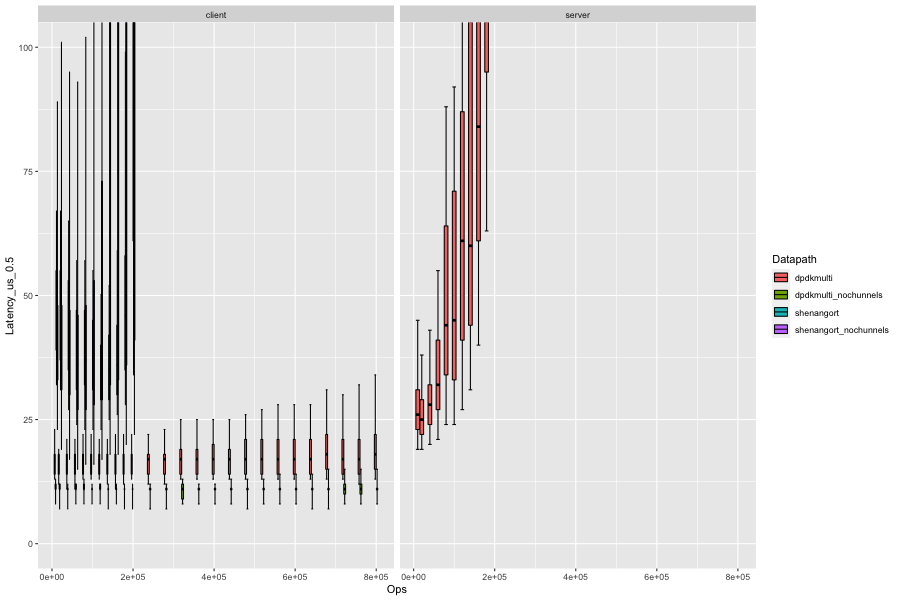

In [58]:
%%R -i df -w 900 -h 600

library(ggplot2)

#geom_boxplot(aes(group=interaction(ShardType,Ops)), position="dodge") + 
#ggplot(pdf, aes(x=Ops, y=Latency_us, 
#  fill=ShardType, group=interaction(ShardType,Ops))) + 
#    stat_summary(fun.data = f, geom="boxplot", position="dodge") + 
#    facet_grid(NumShards~Concurrency) +
#    coord_cartesian(ylim=c(0, 10000))

ggplot(df, aes(x=Ops, fill=Datapath, group=interaction(Datapath,ShardType,Ops))) +
  geom_errorbar(aes(ymin=Latency_us_0.05, ymax = Latency_us_0.95), position="dodge") +
  geom_crossbar(aes(ymin=Latency_us_0.25, y=Latency_us_0.5, ymax = Latency_us_0.75), position="dodge") +
  facet_wrap(~ShardType) +
  coord_cartesian(ylim=c(0, 100))

In [62]:
dpdk = df[(df["Datapath"] == "dpdkmulti") | (df["Datapath"] == "dpdkmulti_nochunnels")]
dpdk.to_csv('kv-mlx5-0a7efa1.csv')

In [59]:
shenango = df[(df["Datapath"] == "shenangort") | (df["Datapath"] == "shenangort_nochunnels")]
shenango

,ShardType,NumShards,Ops,Interarrival_us_0.05,Interarrival_us_0.25,Interarrival_us_0.5,Interarrival_us_0.75,Interarrival_us_0.95,NumOps_0.05,NumOps_0.25,...,Completion_ms_0.95,Latency_us_0.05,Latency_us_0.25,Latency_us_0.5,Latency_us_0.75,Latency_us_0.95,Commit,Datapath,Concurrency,Poisson
68,client,8,10000,1600.0,1600.0,1600.0,1600.0,1600.0,1208207.0,1208207.0,...,242093.0,32.0,39.0,46.0,55.0,67.0,kv-shenango-mlx5-0a7efa1,shenangort,workloadb-8,True
69,client,8,20000,800.0,800.0,800.0,800.0,800.0,1208204.0,1208204.0,...,121239.0,31.0,37.0,47.0,55.0,67.0,kv-shenango-mlx5-0a7efa1,shenangort,workloadb-8,True
70,client,8,40000,400.0,400.0,400.0,400.0,400.0,1208167.0,1208167.0,...,60795.0,27.0,35.0,45.0,53.0,65.0,kv-shenango-mlx5-0a7efa1,shenangort,workloadb-8,True
71,client,8,60000,266.0,266.0,266.0,266.0,266.0,1208268.0,1208268.0,...,40466.0,24.0,31.0,40.0,47.0,57.0,kv-shenango-mlx5-0a7efa1,shenangort,workloadb-8,True
72,client,8,80000,200.0,200.0,200.0,200.0,200.0,1208157.0,1208157.0,...,30541.0,23.0,32.0,39.0,47.0,57.0,kv-shenango-mlx5-0a7efa1,shenangort,workloadb-8,True
73,client,8,100000,160.0,160.0,160.0,160.0,160.0,1208206.0,1208206.0,...,24485.0,23.0,31.0,37.0,45.0,55.0,kv-shenango-mlx5-0a7efa1,shenangort,workloadb-8,True
74,client,8,120000,133.0,133.0,133.0,133.0,133.0,1208209.0,1208209.0,...,20311.0,23.0,29.0,34.0,40.0,50.2,kv-shenango-mlx5-0a7efa1,shenangort,workloadb-8,True
75,client,8,140000,114.0,114.0,114.0,114.0,114.0,1208418.0,1208418.0,...,17502.0,25.0,29.0,35.0,42.0,52.0,kv-shenango-mlx5-0a7efa1,shenangort,workloadb-8,True
76,client,8,160000,100.0,100.0,100.0,100.0,100.0,1208267.0,1208267.0,...,15408.0,26.0,30.0,36.0,44.0,59.0,kv-shenango-mlx5-0a7efa1,shenangort,workloadb-8,True
77,client,8,180000,88.0,88.0,88.0,88.0,88.0,1207962.0,1207962.0,...,13968.0,28.0,35.0,46.0,58.0,99.0,kv-shenango-mlx5-0a7efa1,shenangort,workloadb-8,True


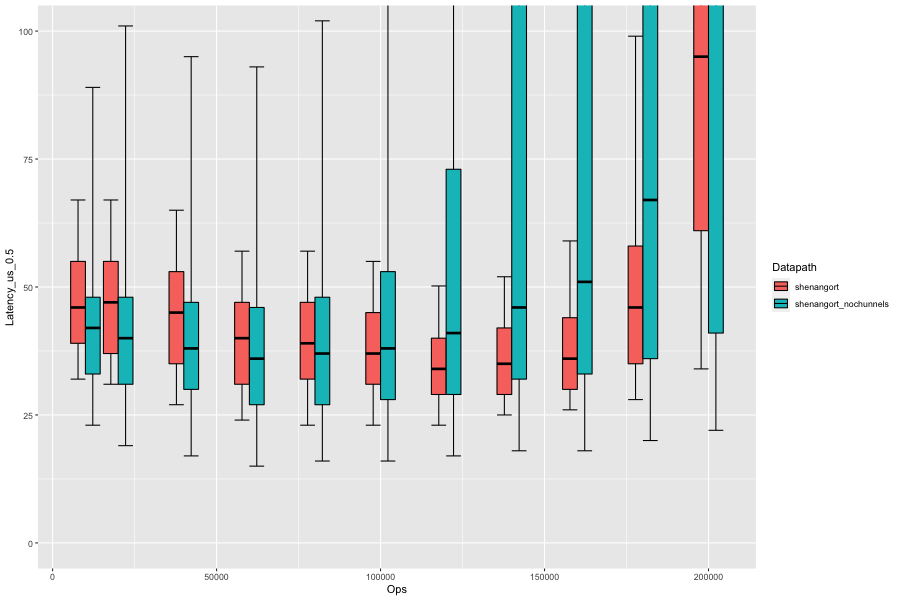

In [60]:
%%R -i shenango -w 900 -h 600

library(ggplot2)

#geom_boxplot(aes(group=interaction(ShardType,Ops)), position="dodge") + 
#ggplot(pdf, aes(x=Ops, y=Latency_us, 
#  fill=ShardType, group=interaction(ShardType,Ops))) + 
#    stat_summary(fun.data = f, geom="boxplot", position="dodge") + 
#    facet_grid(NumShards~Concurrency) +
#    coord_cartesian(ylim=c(0, 10000))

ggplot(shenango, aes(x=Ops, fill=Datapath, group=interaction(Datapath,ShardType,Ops))) +
  geom_errorbar(aes(ymin=Latency_us_0.05, ymax = Latency_us_0.95), position="dodge") +
  geom_crossbar(aes(ymin=Latency_us_0.25, y=Latency_us_0.5, ymax = Latency_us_0.75), position="dodge") +
  coord_cartesian(ylim=c(0, 100))

In [ ]:
%%R -i df -w 1200 -h 400

df$kOps <- df$Ops / 1e3
df <- df[df$kOps == 40 | df$kOps == 80 | df$kOps == 120 | df$kOps == 160 | df$kOps == 200,]

df$nego <- grepl("_no", df$Datapath, fixed=TRUE)

#labs <- c(
#    "kernel" = "Linux",
#    "kernel_noneg" = "Linux-N",
#    "dpdk" = "DPDK",
#    "dpdk_noneg" = "DPDK-N",
#    "shenango_channel" = "Shenango (Ad.)",
#    "shenango_channel_noneg" = "Shenango (Ad.)-N",
#    "shenango_rt" = "Shenango (Rt.)",
#    "shenango_rt_noneg" = "Shenango (Rt.)-N",
#    "shenango_rt_nochunnels" = "Shenango-C"
#)
#values = c(
#    "dpdk" = "#1f78b4",
#    "dpdk_noneg" = "#a6cee3",
#    "kernel" = "#e31a1c",
#    "kernel_noneg" = "#fb9a99",
#    "shenango_channel" = "#33a02c",
#    "shenango_channel_noneg" = "#b2df8a",
#    "shenango_rt" = "#006d2c",
#    "shenango_rt_noneg" = "#74c476",
#    "shenango_rt_nochunnels" = "#aaaaaa"
#),
labs <- c(
    "kernel" = "Linux",
    "kernel_noneg" = "Linux",
    "dpdk" = "DPDK",
    "dpdk_noneg" = "DPDK",
    "shenango_channel" = "Shenango-A",
    "shenango_channel_noneg" = "Shenango-A",
    "shenango_rt" = "Shenango-R",
    "shenango_rt_noneg" = "Shenango-R",
    "shenango_rt_nochunnels" = "Baseline"
)

df$lab <- labs[df$Datapath]

ggplot(df, aes(x=as.factor(kOps), label=lab, color=Datapath, group=interaction(Datapath,lab,kOps))) +
geom_errorbar(aes(ymin=Latency_us_0.05, ymax = Latency_us_0.95), position="dodge") +
geom_crossbar(aes(ymin=Latency_us_0.25, y=Latency_us_0.5, ymax = Latency_us_0.75), position="dodge") +
geom_text(aes(y=100), angle=90, position=position_dodge(width=0.9), show.legend=FALSE) +
facet_wrap(~nego) +
scale_color_manual(
    labels = labs,
    values = c(
        "dpdk" = "#1f78b4",
        "dpdk_noneg" = "#1f78b4",
        "kernel" = "#e31a1c",
        "kernel_noneg" = "#e31a1c",
        "shenango_channel" = "#33a02c",
        "shenango_channel_noneg" = "#33a02c",
        "shenango_rt" = "#006d2c",
        "shenango_rt_noneg" = "#006d2c",
        "shenango_rt_nochunnels" = "#aaaaaa"
    ),
) +
coord_cartesian(ylim=c(0, 350)) +
xlab("Offered Load kOp/sec") + ylab("Request Latency (μs)") +
theme_minimal() +
theme(
    legend.position = "top",
    legend.title=element_blank(),
    text = element_text(size=12, family="IBM Plex Sans", face="bold"),
    axis.text.y = element_text(size=12, family="IBM Plex Sans")
)

#### With a dedicated load balancer

In [151]:
lboutdirs = ["kvlb-dpdk-7f3bba1"]

In [152]:
lbtomls = {}
for outdir in lboutdirs:
    od = f"{rootdir}/{outdir}"
    cfgs = glob.glob(f"{od}/*.toml")
    lbtomls[outdir] = merge_tomls([read_toml(t) for t in cfgs])

lbtomls

{'kvlb-dpdk-7f3bba1': {'iters': 3,
  'wrk': ['./kvstore-ycsb/ycsbc-mock/workloadb-8.access'],
  'datapath': ['dpdkmulti'],
  'load': [10000, 20000, 40000, 60000, 80000, 100000, 120000],
  'poisson-arrivals': [True],
  'shardtype': ['server'],
  'shards': [8],
  'negotiation': [True],
  'optimization': [True, False]}}

In [166]:
def lbcombos():
    for outdir in lboutdirs:
        cfg = lbtomls[outdir]
        datapaths = cfg['datapath']
        num_shards = cfg['shards']
        ops = cfg['load']
        poisson = cfg['poisson-arrivals']
        wrk = [x.split('/')[-1].split('.')[0] for x in cfg['wrk']]
        if 'optimization' not in cfg:
            cfg['optimization'] = [False]
        opti = cfg['optimization']
        iters = cfg['iters']
        
        for dp in datapaths:
            for p in opti:
                d = f"{dp}{'_opt' if p else ''}"
                for ns in num_shards:
                    for o in ops:
                        o = int(o)
                        for p in poisson:
                            for c in wrk:
                                for i in range(iters):
                                    yield read_exp.remote(outdir, d, ns, 'remote', f"load={o}", p, c, i)

lb = pd.concat(ray.get([x for x in lbcombos()]))
lb = lb.reset_index()
lb["Ops"] = lb["Ops"].apply(lambda x: int(x.split('=')[-1]))
lb

,ShardType,NumShards,Ops,Interarrival_us_0.05,Interarrival_us_0.25,Interarrival_us_0.5,Interarrival_us_0.75,Interarrival_us_0.95,NumOps_0.05,NumOps_0.25,...,Latency_us_0.05,Latency_us_0.25,Latency_us_0.5,Latency_us_0.75,Latency_us_0.95,Commit,Datapath,Concurrency,Poisson,Iter
0,remote,8,10000,800.0,800.0,800.0,800.0,800.0,1213934.0,1213934.0,...,21.0,24.0,25.0,28.0,34.0,kvlb-dpdk-7f3bba1,dpdkmulti_opt,workloadb-8,True,0
1,remote,8,10000,800.0,800.0,800.0,800.0,800.0,1213917.0,1213917.0,...,22.0,23.0,26.0,29.0,34.0,kvlb-dpdk-7f3bba1,dpdkmulti_opt,workloadb-8,True,1
2,remote,8,10000,800.0,800.0,800.0,800.0,800.0,1213927.0,1213927.0,...,21.0,23.0,25.0,28.0,32.0,kvlb-dpdk-7f3bba1,dpdkmulti_opt,workloadb-8,True,2
3,remote,8,20000,400.0,400.0,400.0,400.0,400.0,1213804.0,1213804.0,...,22.0,24.0,26.0,30.0,38.0,kvlb-dpdk-7f3bba1,dpdkmulti_opt,workloadb-8,True,0
4,remote,8,20000,400.0,400.0,400.0,400.0,400.0,1213842.0,1213842.0,...,22.0,24.0,25.0,30.0,37.0,kvlb-dpdk-7f3bba1,dpdkmulti_opt,workloadb-8,True,1
5,remote,8,20000,400.0,400.0,400.0,400.0,400.0,1213838.0,1213838.0,...,22.0,24.0,26.0,30.0,37.0,kvlb-dpdk-7f3bba1,dpdkmulti_opt,workloadb-8,True,2
6,remote,8,40000,200.0,200.0,200.0,200.0,200.0,1213704.0,1213704.0,...,22.0,26.0,29.0,31.0,36.0,kvlb-dpdk-7f3bba1,dpdkmulti_opt,workloadb-8,True,0
7,remote,8,40000,200.0,200.0,200.0,200.0,200.0,1213748.0,1213748.0,...,22.0,25.0,29.0,31.0,36.0,kvlb-dpdk-7f3bba1,dpdkmulti_opt,workloadb-8,True,1
8,remote,8,40000,200.0,200.0,200.0,200.0,200.0,1213735.0,1213735.0,...,22.0,25.0,30.0,32.0,36.0,kvlb-dpdk-7f3bba1,dpdkmulti_opt,workloadb-8,True,2
9,remote,8,60000,133.0,133.0,133.0,133.0,133.0,1213439.0,1213439.0,...,23.0,29.0,41.0,48.0,51.0,kvlb-dpdk-7f3bba1,dpdkmulti_opt,workloadb-8,True,0


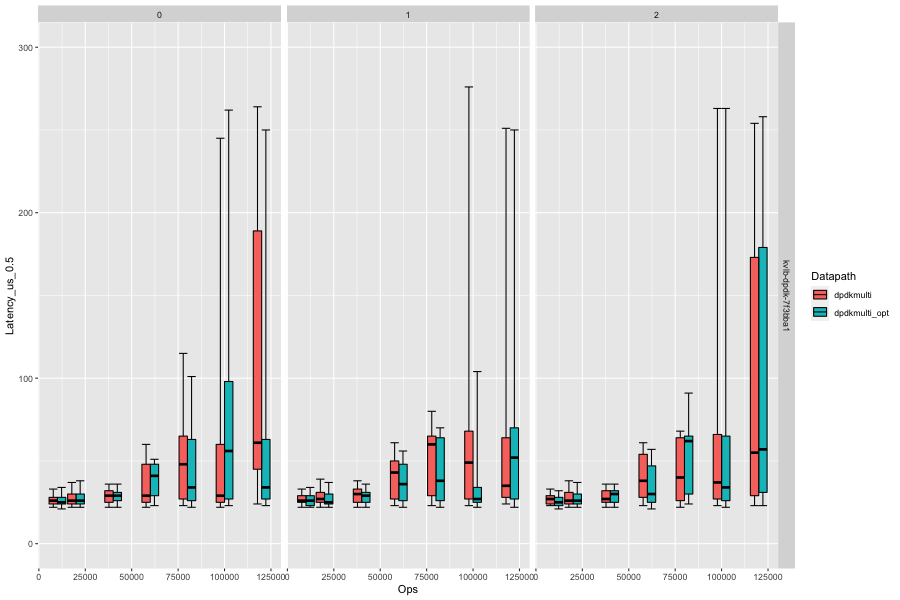

In [168]:
%%R -i lb -w 900 -h 600

#f <- function(x) {
#  r <- quantile(x, probs = c(0.05, 0.25, 0.5, 0.75, 0.95))
#  names(r) <- c("ymin", "lower", "middle", "upper", "ymax")
#  r
#}

ggplot(lb, aes(x=Ops, fill=Datapath, group=interaction(Datapath,Ops))) +
  geom_errorbar(aes(ymin=Latency_us_0.05, ymax = Latency_us_0.95), position="dodge") +
  geom_crossbar(aes(ymin=Latency_us_0.25, y=Latency_us_0.5, ymax = Latency_us_0.75), position="dodge") +
  facet_grid(Commit~Iter) +
  coord_cartesian(ylim=c(0, 300))